<a href="https://colab.research.google.com/github/sundarjhu/AstrostatsIRyA2023/blob/main/Astrostatistics_Lecture14_20201204.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


#Example of an $F$-test from Sec. 8.2 of Barlow
### Do physics and engineering students get the same grades on a test?
#### The answer is "Yes" if the mean of the grades for physics students is the same as that for the engineering students. This can be determined using a "standard" $t$-test.
#### But we first have to confirm that the two sets of grades **have the same population variance**, for which we perform an $F$-test.
---



In [21]:
import numpy as np
#Grades for physics students
data1 = np.array([39, 18, 3, 22, 24, 29, 22, 22, 27, 28, 23, 48])
#Grades for engineering students
data2 = np.array([42, 23, 36, 35, 38, 42, 33])

##### IMPORTANT! Define $F$ in such a way that its observed value $>1$.

In [3]:
#Construct the observed F-statistic
var1 = data1.var(ddof = 1)
var2 = data2.var(ddof = 1)
#Define F such that F > 1
if var1 > var2:
  F = var1 / var2
  dof1 = len(data1) - 1
  dof2 = len(data2) - 1
else:
  F = var2 / var1
  dof1 = len(data2) - 1
  dof2 = len(data1) - 1

print(f"The observed value of the F statistic is {np.round(F, decimals=2)}")

The observed value of the F statistic is 2.83


In [4]:
#Perform the F-test
from scipy.stats import f
alpha = 0.05
#Calculate number of degrees of freedom for both data sets
dof1 = len(data1) - 1
dof2 = len(data2) - 1
pvalue = 1 - f.cdf(F, dof1, dof2)
if pvalue <= alpha:
  print("The p-value, {}, is lesser than the significance. The null hypothesis can be rejected!".format(np.format_float_scientific(pvalue, precision = 3)))
else:
  print("The p-value, {}, is greater than the significance. There is no evidence for any difference in the population variances!".format(np.format_float_scientific(pvalue, precision = 3)))

The p-value, 1.064e-01, is greater than the significance. There is no evidence for any difference in the population variances!


# Example of an $F$-test: testing for variability in light curves
## For an application in the literature, see [Goyal et al. 2012 A&A 544A 37](https://ui.adsabs.harvard.edu/abs/2012A%26A...544A..37G/abstract).

### The intrinsic variability is modelled as a sinusoidal wave, sampled on a non-uniform grid as is usually the case with observations.

In [80]:
#Generate true flux of source with intrinsic sinusoidal variability
import numpy as np
def sinewave(t, period=12.0, amp=1.0, f_mean=5.0):
  """
  Given a grid of time values t, return a sine wave with
    the specified period, peak-to-peak amplitude, and mean flux
  Arguments:
  t -- grid of time values (same units as period)
  period -- period of wave
  amp -- peak-to-peak amplitude
  f_mean -- mean flux
  """
  return f_mean + 0.5 * amp * np.sin(2 * np.pi * t / period)

period=12.0
amp=1.0
f_mean=1.0
n_obs = 22
#n_obs observations taken at randomly spaced times over 3.3 * period days
seed = 1001
np.random.seed(seed)
t = np.random.choice(np.linspace(0, 3.3 * period, 2 * n_obs), size = n_obs)
t = t[np.argsort(t)] # since they are randomly sampled, we sort the resulting times!
f_true = sinewave(t, period=period, amp=amp, f_mean=f_mean)

### Let's visualise the true flux of this source

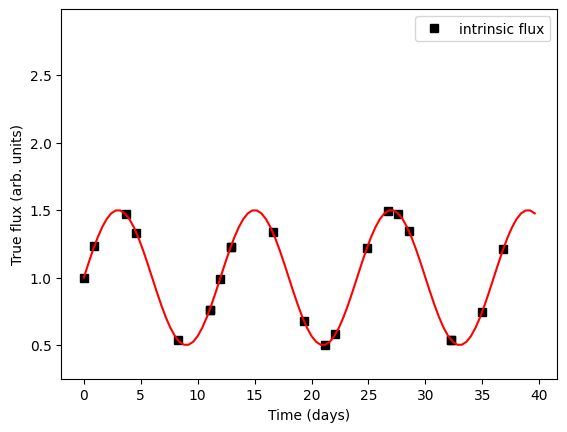


The peak-to-peak amplitude calculated from the data is 0.992


In [81]:
from matplotlib import pyplot as plt
plt.plot(t, f_true, 'ks', label='intrinsic flux')
tgrid = np.linspace(0, 3.3 * period, 100)
plt.plot(tgrid, sinewave(tgrid, period=period, amp=amp, f_mean=f_mean), 'r-')
plt.ylim(0.5 * np.min(f_true), 2 * np.max(f_true))
plt.xlabel('Time (days)'); plt.ylabel('True flux (arb. units)')
plt.legend(loc='best')
plt.show()
print()
print(f"The peak-to-peak amplitude calculated from the data is "
f"{np.round(f_true.max() - f_true.min(), decimals = 3)}")

### The measurement errors are assumed to be Gaussian centered at zero.

In [105]:
#Simulate measurement errors
from scipy.stats import norm, uniform
np.random.seed(seed) # for reproducibility
noise = np.abs(norm.rvs(loc=0.0, scale=amp / 2, size=len(t)))

### The variability in the observed flux is a combination of the intrinsic variability and that due to the measurement error.

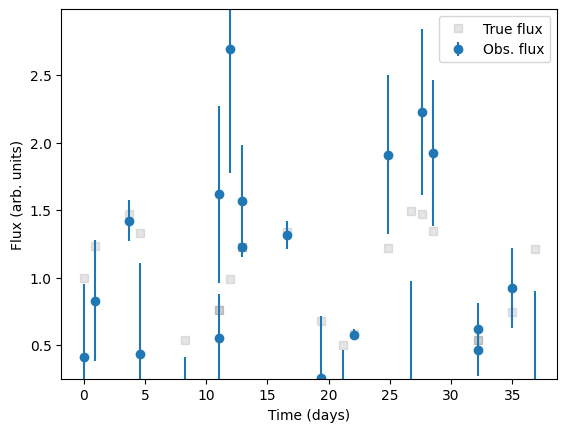

In [106]:
#Visualise observed data
np.random.seed(1001) # for reproducibility
f_obs = norm.rvs(loc=f_true, scale=noise)
plt.plot(t, f_true, 'ks', label = 'True flux', alpha = 0.1)
# plt.plot(t, f_obs, 'ro', label = 'Obs. flux')
plt.errorbar(t, f_obs, yerr=noise, fmt='o', label='Obs. flux')
plt.ylim(0.5 * np.min(f_true), 2 * np.max(f_true))
plt.xlabel('Time (days)'); plt.ylabel('Flux (arb. units)')
plt.legend(loc = 'best')
plt.show()
#difficult to decouple true variability from variance due to measurement uncertainty

### The $F$-test is performed to determine whether the data show significant evidence for variability.

In [107]:
#Construct F-statistic
# F_obs = observed variance in the flux / expected variance if H0 is true
#         \approx observed variance in the flux / mean of squares of flux uncertainties
F_obs = f_obs.var(ddof = 1) / (noise**2).mean()
#Check that it is larger than 1; otherwise there's no point in trying to confirm variability
if F_obs > 1:
  print(f"The F-statistic = {np.round(F_obs, decimals=2)} > 1!")
else:
  print(f"The F-statistic = {np.round(F_obs, decimals=2)} < 1, no point trying to detect variability")

The F-statistic = 2.38 > 1!


In [108]:
#Can we reject the H0 = 'The observed variability is only due to the measurement uncertainties'?
from scipy.stats import f
alpha = 0.05
df1 = len(f_obs) - 1
df2 = len(noise) - 1
#p-value = P(F > observed value) = 1 - P(F <= observed value) = 1 - CDF(observed value)
pvalue = 1 - f.cdf(F_obs, df1, df2)
print(f"The p-value of the observed F-statistic is {np.round(pvalue, decimals=4)}")
if pvalue <= alpha:
  print("The p-value is less than the significance, the null hypothesis can be rejected!")
else:
  print("The p-value is greater than the significance, the null hypothesis cannot be rejected.")

The p-value of the observed F-statistic is 0.0266
The p-value is less than the significance, the null hypothesis can be rejected!


### NOTE: the significance for the $F$ test might have to be lowered (0.01 to 0.001!) for high-quality variability detection/characterisation. See the discussion in [Goyal et al. 2012 A&A 544A 37](https://ui.adsabs.harvard.edu/abs/2012A%26A...544A..37G/abstract).

# Spearman rank correlation test
### Much more robust than the Pearson test!

PearsonRResult(statistic=0.9706709156963573, pvalue=7.110814657396471e-07)
SignificanceResult(statistic=1.0, pvalue=0.0)


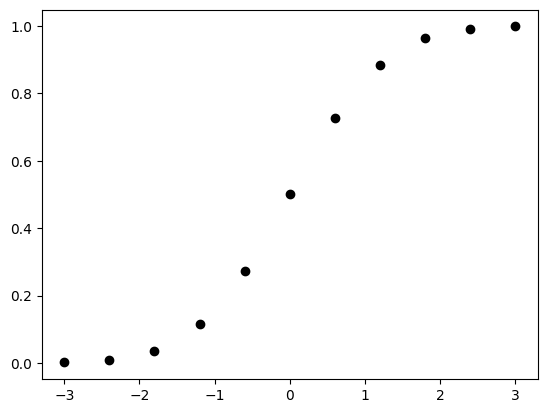

In [73]:
from scipy.stats import pearsonr, spearmanr
x = np.linspace(-3, 3, 11)
y = norm.cdf(x)
print(pearsonr(x, y))
print(spearmanr(x, y))
plt.plot(x, y, 'ko')
plt.show()

PearsonRResult(statistic=0.3000121651531767, pvalue=0.37006276225238033)
SignificanceResult(statistic=0.9727272727272729, pvalue=5.14217704904919e-07)


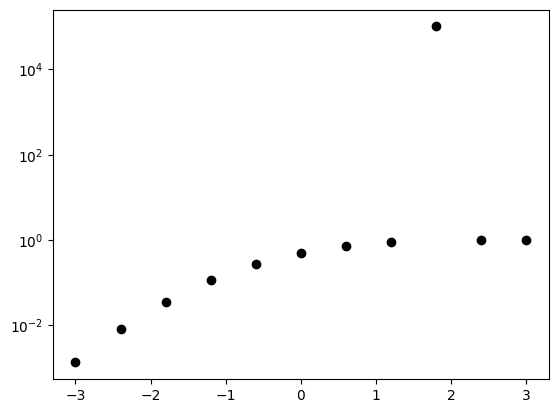

In [74]:
from scipy.stats import pearsonr, spearmanr
y[8] = 1e5
print(pearsonr(x, y))
print(spearmanr(x, y))
plt.plot(x, y, 'ko')
plt.yscale('log')
plt.show()